In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
from sklearn.model_selection import train_test_split

def read_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    input_data = []
    target_data = []
    
    for i, line in enumerate(lines):
        # print(i, line)
        if i % 2 == 0:  # Input data (rows 1, 3, 5, 7, ...)
            input_data.append([float(x) for x in line.strip().split()])
        else:          # Target data (rows 2, 4, 6, 8, ...)
            target_data.append([float(x) for x in line.strip().split()])

    # Convert to NumPy arrays and reshape
    input_array = np.array(input_data).reshape(-1, 9)
    target_array = np.array(target_data).reshape(-1, 1)
    
    return input_array, target_array

check_target = True

def rgb2gray(rgb):
    assert len(rgb.shape) == 3, 'input image must be 3D'
    assert rgb.shape[2] == 3, 'input image must be RGB'
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def im2col(image, kernel_shape=(3, 3), stride=1, padding=0):
    h, w = image.shape
    kh, kw = kernel_shape

    # Apply padding if needed
    if padding > 0:
        image_padded = np.pad(image, pad_width=((padding, padding), (padding, padding)), mode='constant', constant_values=0)
    else:
        image_padded = image

    # Calculate the output dimensions
    oh = (h - kh + 2 * padding) // stride + 1
    ow = (w - kw + 2 * padding) // stride + 1

    # Create an empty output array
    output = np.zeros((oh * ow, kh * kw))

    # Iterate and extract 3x3 patches
    idx = 0
    for y in range(0, h - kh + 1, stride):
        for x in range(0, w - kw + 1, stride):
            patch = image_padded[y:y+kh, x:x+kw]
            output[idx] = patch.flatten()
            idx += 1

    return output

def sobel_zhu(array):
    result = np.zeros((array.shape[0],))
    for i in range(array.shape[0]):
        img = array[i].reshape(3, 3)
        sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        img_x = np.abs(np.sum(img * sobel_x))
        img_y = np.abs(np.sum(img * sobel_y))
        img = np.sqrt(img_x ** 2 + img_y ** 2)
        if img > 0.707:
            img = 0.707
        result[i] = img
    return result

real_img = np.load('jpegdata/3.npy')
print(real_img.shape)
real_img = rgb2gray(real_img) / 255.0 # shape = (256, 256)

# rearange the image to 3x3 patches
real_img = im2col(real_img)

# apply sobel filter
sobel_value = sobel_zhu(real_img).reshape(-1, 1)

# split the data and target into train and test.
train_in, test_in, train_target, test_target = train_test_split(real_img, sobel_value, test_size=0.1, random_state=6)

# check the min and max value of the target
if check_target:
    print("min:", np.min(train_target), "max:", np.max(train_target))
    # min: 6.10052909256606e-05 max: 0.707; all in (0,1), no need to scale.

# convert to tensor
train_in, train_target = torch.from_numpy(train_in).float(), torch.from_numpy(train_target).float()
test_in, test_target = torch.from_numpy(test_in).float(), torch.from_numpy(test_target).float()

# check the shape of the data   
print("train_in:", train_in.shape, "train_target:", train_target.shape)
print("test_in:", test_in.shape, "test_target:", test_target.shape)


class dianet2(nn.Module):
    def __init__(self):
        super(dianet2, self).__init__()
        self.fc1 = nn.Linear(9, 6)
        self.fc2 = nn.Linear(6, 5)
        self.fc3 = nn.Linear(5, 4)
        self.fc4 = nn.Linear(4, 3)
        self.fc5 = nn.Linear(3, 2)
        self.fc6 = nn.Linear(2, 1)

        self.msk1 = np.array([[1,0,0,0,0,0,0,0,0],[1,1,1,0,0,0,0,0,0],[0,0,1,1,1,0,0,0,0],[0,0,0,0,1,1,1,0,0],[0,0,0,0,0,0,1,1,1],[0,0,0,0,0,0,0,0,1]])
        self.msk2 = np.array([[1,1,0,0,0,0],[0,1,1,0,0,0],[0,0,1,1,0,0],[0,0,0,1,1,0],[0,0,0,0,1,1]])
        self.msk3 = np.array([[1,1,0,0,0],[0,1,1,0,0],[0,0,1,1,0],[0,0,0,1,1]])
        self.msk4 = np.array([[1,1,0,0],[0,1,1,0],[0,0,1,1]])
        self.msk5 = np.array([[1,1,0],[0,1,1]])

    def forward(self, x, dwn=-1, up=1):
        self.fc1.weight.data *= (torch.from_numpy(self.msk1).float()).to(x.device)
        self.fc1.weight.data = torch.clamp(self.fc1.weight.data, dwn, up)
        self.fc1.bias.data = torch.clamp(self.fc1.bias.data, dwn, up)
        x1 = F.leaky_relu(self.fc1(x)) # 6

        self.fc2.weight.data *= (torch.from_numpy(self.msk2).float()).to(x.device)
        self.fc2.weight.data = torch.clamp(self.fc2.weight.data, dwn, up)
        self.fc2.bias.data = torch.clamp(self.fc2.bias.data, dwn, up)
        x2 = F.leaky_relu(self.fc2(x1)) # 5

        self.fc3.weight.data *= (torch.from_numpy(self.msk3).float()).to(x.device)
        self.fc3.weight.data = torch.clamp(self.fc3.weight.data, dwn, up)
        self.fc3.bias.data = torch.clamp(self.fc3.bias.data, dwn, up)
        x3 = F.leaky_relu(self.fc3(x2)) # 4
        x3 = x3+x1[:,1:-1]

        self.fc4.weight.data *= (torch.from_numpy(self.msk4).float()).to(x.device)
        self.fc4.weight.data = torch.clamp(self.fc4.weight.data, dwn, up)
        self.fc4.bias.data = torch.clamp(self.fc4.bias.data, dwn, up)
        x4 = F.leaky_relu(self.fc4(x3)) # 3
        x4 = x4+x2[:,1:-1]

        self.fc5.weight.data *= (torch.from_numpy(self.msk5).float()).to(x.device)
        self.fc5.weight.data = torch.clamp(self.fc5.weight.data, dwn, up)
        self.fc5.bias.data = torch.clamp(self.fc5.bias.data, dwn, up)
        x5 = F.leaky_relu(self.fc5(x4)) # 2
        x5 = x5+x3[:,1:-1]

        x6 = F.leaky_relu(self.fc6(x5)) # 1
        self.fc6.weight.data = torch.clamp(self.fc6.weight.data, dwn, up)
        self.fc6.bias.data = torch.clamp(self.fc6.bias.data, dwn, up)
        x6 = x6+x4[:,1:-1]

        return x6
    

(512, 512, 3)
min: 6.10052909256606e-05 max: 0.707
train_in: torch.Size([234090, 9]) train_target: torch.Size([234090, 1])
test_in: torch.Size([26010, 9]) test_target: torch.Size([26010, 1])


In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = dianet2().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_min = 1000
for epoch in range(500):
    batch_size = 16
    count = 0
    epoch_loss = 0
    for i in range(0, train_in.shape[0], batch_size):
        count += 1
        optimizer.zero_grad()
        inputs = train_in[i:i+batch_size].to(device)
        targets = train_target[i:i+batch_size].to(device)
        outputs = model(inputs, -100, 100)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= count
    
    # test current model
    model.eval()
    with torch.no_grad():
        outputs = model(test_in.to(device), -100, 100)
        test_loss = criterion(outputs, test_target.to(device))
        test_loss = test_loss.item()
        if test_loss < loss_min:
            loss_min = test_loss
            torch.save(model.state_dict(), 'sobel_data/dianet_nolimit.pth')
            print('saved at epoch', epoch, 'loss', loss_min)
        

saved at epoch 0 loss 0.023642273619771004
saved at epoch 1 loss 0.021999966353178024
saved at epoch 2 loss 0.019673580303788185
saved at epoch 3 loss 0.01843016967177391
saved at epoch 4 loss 0.017144152894616127
saved at epoch 5 loss 0.01631159335374832
saved at epoch 6 loss 0.01572735421359539
saved at epoch 7 loss 0.014874933287501335
saved at epoch 8 loss 0.01435165572911501
saved at epoch 10 loss 0.01337036956101656
saved at epoch 11 loss 0.013346676714718342
saved at epoch 13 loss 0.013048410415649414
saved at epoch 14 loss 0.01295387465506792
saved at epoch 15 loss 0.012432735413312912
saved at epoch 16 loss 0.012398949824273586
saved at epoch 17 loss 0.012375544756650925
saved at epoch 18 loss 0.012085048481822014
saved at epoch 20 loss 0.01192584540694952
saved at epoch 21 loss 0.011867735534906387
saved at epoch 22 loss 0.011516595259308815
saved at epoch 27 loss 0.011249338276684284
saved at epoch 28 loss 0.011216703802347183
saved at epoch 29 loss 0.011109117418527603
save

KeyboardInterrupt: 

# clamp -1,1

real sobel shape:  (260100, 1)
model sobel shape:  (260100, 1)
average root-mean-square (RMS) difference:  0.08237396586143753


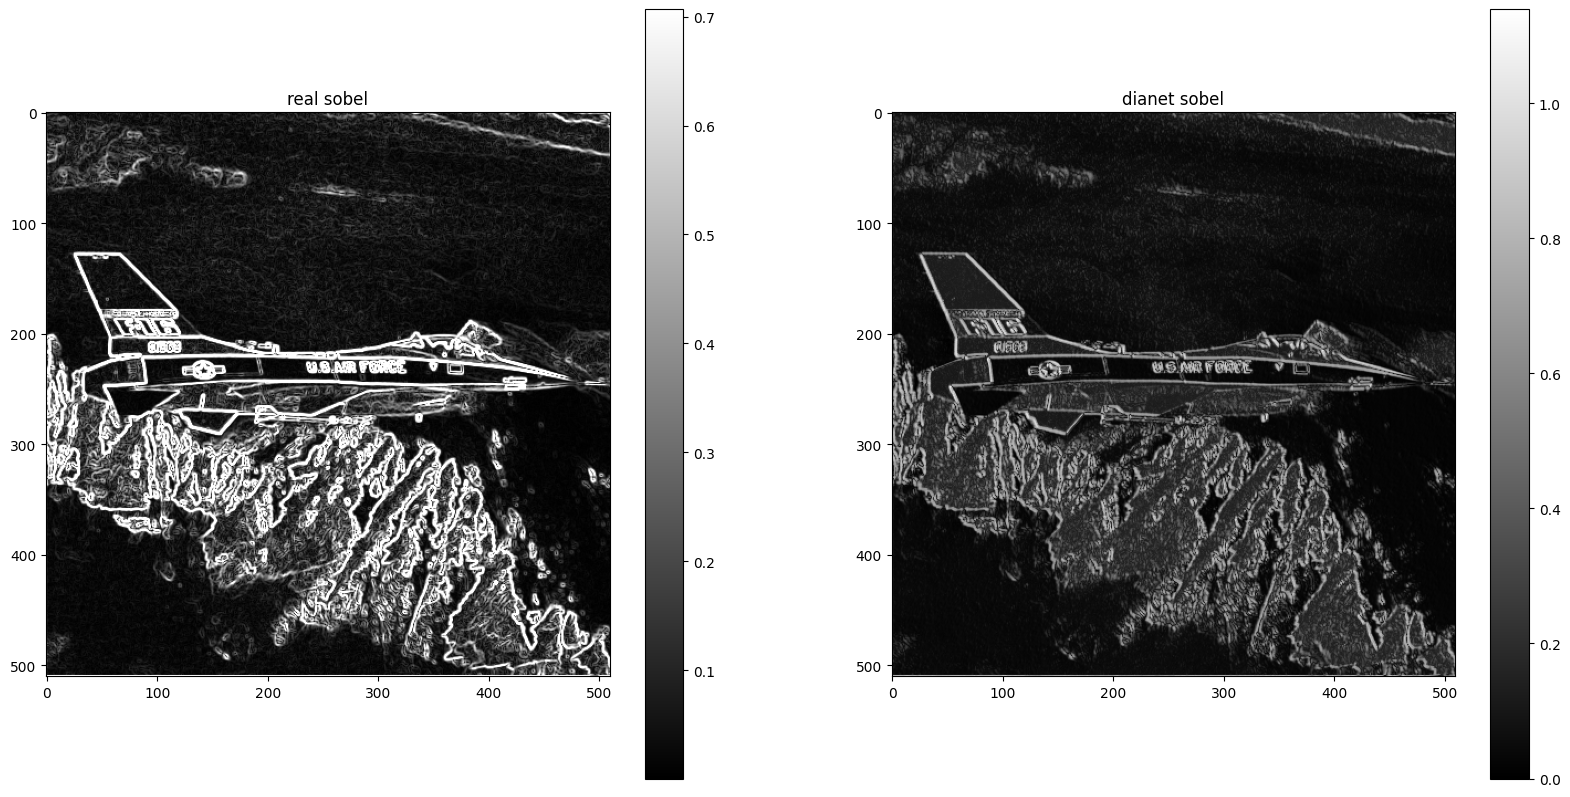

In [2]:
def rgb2gray(rgb):
    assert len(rgb.shape) == 3, 'input image must be 3D'
    assert rgb.shape[2] == 3, 'input image must be RGB'
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def im2col(image, kernel_shape=(3, 3), stride=1, padding=0):
    h, w = image.shape
    kh, kw = kernel_shape

    # Apply padding if needed
    if padding > 0:
        image_padded = np.pad(image, pad_width=((padding, padding), (padding, padding)), mode='constant', constant_values=0)
    else:
        image_padded = image

    # Calculate the output dimensions
    oh = (h - kh + 2 * padding) // stride + 1
    ow = (w - kw + 2 * padding) // stride + 1

    # Create an empty output array
    output = np.zeros((oh * ow, kh * kw))

    # Iterate and extract 3x3 patches
    idx = 0
    for y in range(0, h - kh + 1, stride):
        for x in range(0, w - kw + 1, stride):
            patch = image_padded[y:y+kh, x:x+kw]
            output[idx] = patch.flatten()
            idx += 1

    return output

def sobel_zhu(array):
    result = np.zeros((array.shape[0],))
    for i in range(array.shape[0]):
        img = array[i].reshape(3, 3)
        sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        img_x = np.abs(np.sum(img * sobel_x))
        img_y = np.abs(np.sum(img * sobel_y))
        img = np.sqrt(img_x ** 2 + img_y ** 2)
        if img > 0.707:
            img = 0.707
        result[i] = img
    return result


real_img = np.load('jpegdata/3.npy')

# to gray, and normalize
real_img = rgb2gray(real_img) / 255.0

# rearange image to 3*3 patches, and calculate sobel
real_col = im2col(real_img)
real_sobel = sobel_zhu(real_col).reshape(-1,1)

# ------------------ model sobel ------------------
model = dianet2()
criterion = nn.MSELoss()
model.load_state_dict(torch.load('sobel_data/dianet-11.pth'))
model.eval()
model_sobel = model(torch.from_numpy(real_col).float(), -1, 1).detach().numpy()

# # calculate accuracy
# accuracy = np.sum(real_sobel == model_sobel)/real_sobel.shape[0]
# print('accuracy: ', accuracy)

def image_difference_error_rate(image1, image2):
    if image1.shape != image2.shape:
        raise ValueError("The two images must have the same dimensions.")
    # Calculate the squared difference between the two images
    diff = (image1 - image2) ** 2
    # Calculate the mean squared difference
    mean_squared_diff = np.mean(diff)
    # Take the square root to get the root mean square difference
    rms_diff = np.sqrt(mean_squared_diff)
    # Normalize the RMS difference to get the error rate
    error_rate = rms_diff / max(np.max(image1), np.max(image2))

    return error_rate

# average root-mean-square (RMS) difference
error_rate = image_difference_error_rate(real_sobel, model_sobel)
print('average root-mean-square (RMS) difference: ', error_rate)

# ******************** plot ********************
import matplotlib.pyplot as plt
# calculate sobel label's reshape shape
sobel_shape = (real_img.shape[0]-2, real_img.shape[1]-2)

# compare real and model's sobel
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(real_sobel.reshape(sobel_shape), cmap='gray')
plt.colorbar()
plt.title('real sobel')

plt.subplot(1,2,2)
plt.imshow(model_sobel.reshape(sobel_shape), cmap='gray')
plt.colorbar()
plt.title('dianet sobel')

plt.show()

# clamp 0,1

average root-mean-square (RMS) difference:  0.29546839668989944


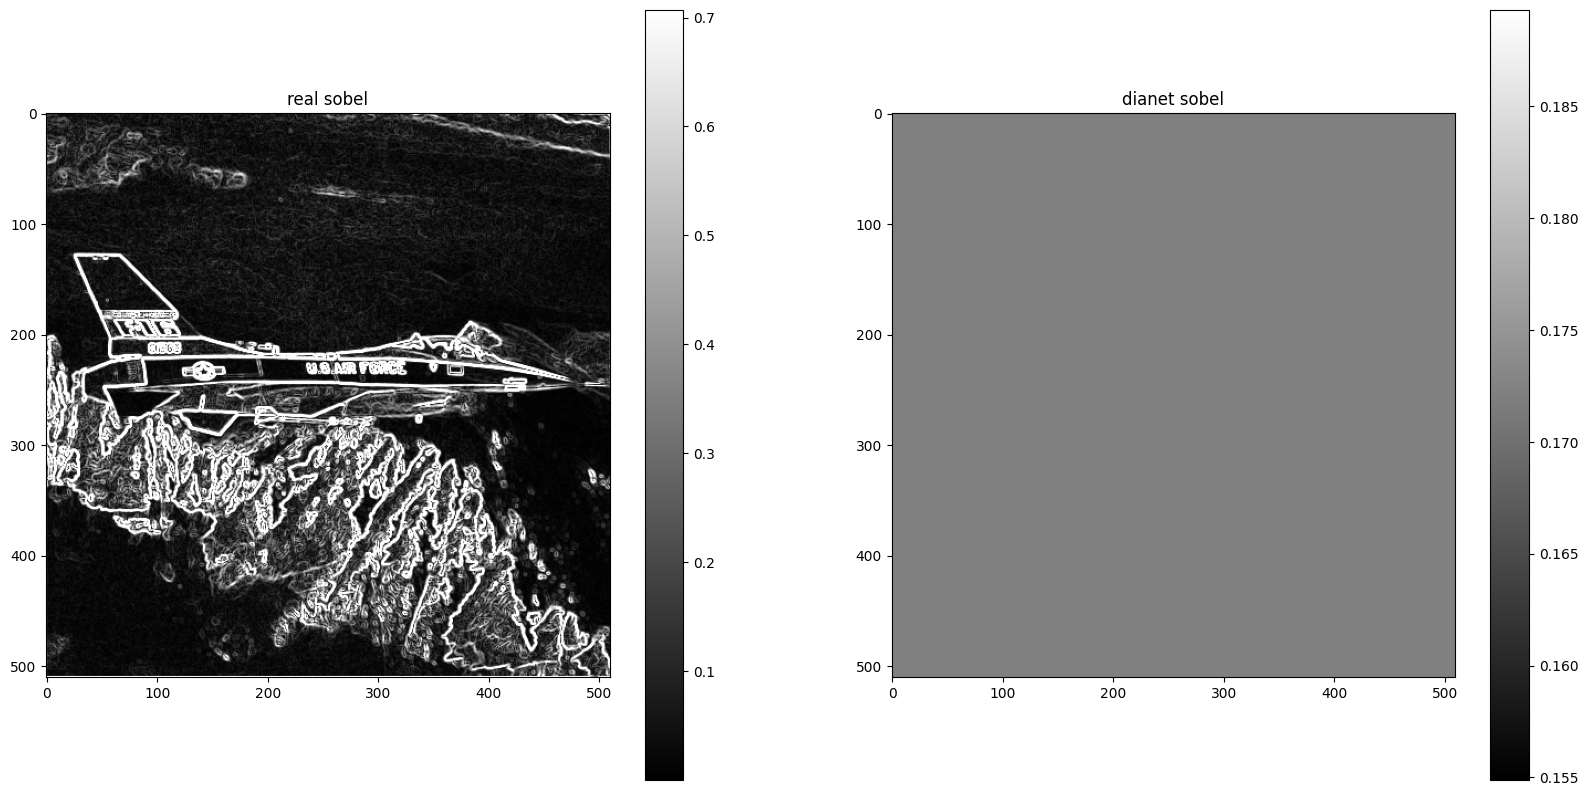

In [3]:
def rgb2gray(rgb):
    assert len(rgb.shape) == 3, 'input image must be 3D'
    assert rgb.shape[2] == 3, 'input image must be RGB'
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def im2col(image, kernel_shape=(3, 3), stride=1, padding=0):
    h, w = image.shape
    kh, kw = kernel_shape

    # Apply padding if needed
    if padding > 0:
        image_padded = np.pad(image, pad_width=((padding, padding), (padding, padding)), mode='constant', constant_values=0)
    else:
        image_padded = image

    # Calculate the output dimensions
    oh = (h - kh + 2 * padding) // stride + 1
    ow = (w - kw + 2 * padding) // stride + 1

    # Create an empty output array
    output = np.zeros((oh * ow, kh * kw))

    # Iterate and extract 3x3 patches
    idx = 0
    for y in range(0, h - kh + 1, stride):
        for x in range(0, w - kw + 1, stride):
            patch = image_padded[y:y+kh, x:x+kw]
            output[idx] = patch.flatten()
            idx += 1

    return output

def sobel_zhu(array):
    result = np.zeros((array.shape[0],))
    for i in range(array.shape[0]):
        img = array[i].reshape(3, 3)
        sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        img_x = np.abs(np.sum(img * sobel_x))
        img_y = np.abs(np.sum(img * sobel_y))
        img = np.sqrt(img_x ** 2 + img_y ** 2)
        if img > 0.707:
            img = 0.707
        result[i] = img
    return result

real_img = np.load('jpegdata/3.npy')

# to gray, and normalize
real_img = rgb2gray(real_img) / 255.0

# rearange image to 3*3 patches, and calculate sobel
real_col = im2col(real_img)
real_sobel = sobel_zhu(real_col).reshape(-1,1)


# ------------------ model sobel ------------------
model = dianet2()
criterion = nn.MSELoss()
model.load_state_dict(torch.load('sobel_data/dianet01.pth'))
model.eval()
model_sobel = model(torch.from_numpy(real_col).float(), 0, 1).detach().numpy()


# # calculate accuracy
# accuracy = np.sum(real_sobel == model_sobel)/real_sobel.shape[0]
# print('accuracy: ', accuracy)

def image_difference_error_rate(image1, image2):
    if image1.shape != image2.shape:
        raise ValueError("The two images must have the same dimensions.")
    # Calculate the squared difference between the two images
    diff = (image1 - image2) ** 2
    # Calculate the mean squared difference
    mean_squared_diff = np.mean(diff)
    # Take the square root to get the root mean square difference
    rms_diff = np.sqrt(mean_squared_diff)
    # Normalize the RMS difference to get the error rate
    error_rate = rms_diff / max(np.max(image1), np.max(image2))

    return error_rate

# average root-mean-square (RMS) difference
error_rate = image_difference_error_rate(real_sobel, model_sobel)
print('average root-mean-square (RMS) difference: ', error_rate)

# ******************** plot ********************
import matplotlib.pyplot as plt
# calculate sobel label's reshape shape
sobel_shape = (real_img.shape[0]-2, real_img.shape[1]-2)

# compare real and model's sobel
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(real_sobel.reshape(sobel_shape), cmap='gray')
plt.colorbar()
plt.title('real sobel')

plt.subplot(1,2,2)
plt.imshow(model_sobel.reshape(sobel_shape), cmap='gray')
plt.colorbar()
plt.title('dianet sobel')

plt.show()

# no limit

real sobel shape:  (260100, 1)
model sobel shape:  (260100, 1)
average root-mean-square (RMS) difference:  0.05184078952357477


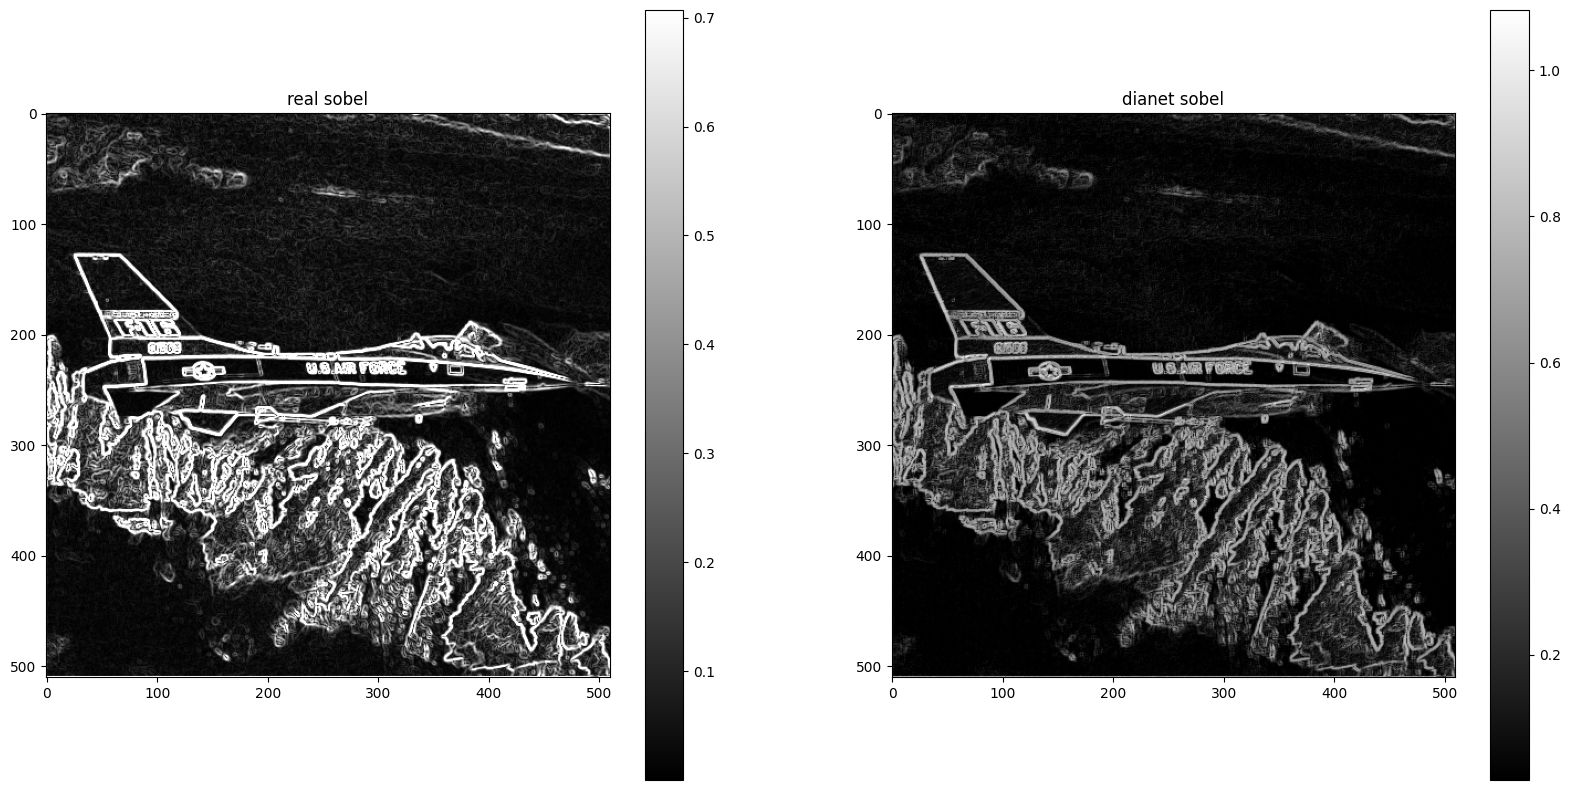

In [23]:
real_img = np.load('jpegdata/3.npy')

# to gray, and normalize
real_img = rgb2gray(real_img) / 255.0

# rearange image to 3*3 patches, and calculate sobel
real_col = im2col(real_img)
real_sobel = sobel_zhu(real_col).reshape(-1,1)

# binary the sobel by threshold
# real_sobel[real_sobel>np.percentile(real_sobel, ths)], real_sobel[real_sobel<=np.percentile(real_sobel, ths)] = 1, 0
print('real sobel shape: ', real_sobel.shape)

# ------------------ model sobel ------------------
model = dianet2()
criterion = nn.MSELoss()
model.load_state_dict(torch.load('sobel_data/dianet_nolimit.pth'))
model.eval()
model_sobel = model(torch.from_numpy(real_col).float(), -100, 100).detach().numpy()

# model_sobel[model_sobel>np.percentile(model_sobel, ths)], model_sobel[model_sobel<=np.percentile(model_sobel, ths)] = 1, 0
print('model sobel shape: ', model_sobel.shape)

# # calculate accuracy
# accuracy = np.sum(real_sobel == model_sobel)/real_sobel.shape[0]
# print('accuracy: ', accuracy)

def image_difference_error_rate(image1, image2):
    if image1.shape != image2.shape:
        raise ValueError("The two images must have the same dimensions.")
    # Calculate the squared difference between the two images
    diff = (image1 - image2) ** 2
    # Calculate the mean squared difference
    mean_squared_diff = np.mean(diff)
    # Take the square root to get the root mean square difference
    rms_diff = np.sqrt(mean_squared_diff)
    # Normalize the RMS difference to get the error rate
    error_rate = rms_diff / max(np.max(image1), np.max(image2))

    return error_rate

# average root-mean-square (RMS) difference
error_rate = image_difference_error_rate(real_sobel, model_sobel)
print('average root-mean-square (RMS) difference: ', error_rate)

# ******************** plot ********************
import matplotlib.pyplot as plt
# calculate sobel label's reshape shape
sobel_shape = (real_img.shape[0]-2, real_img.shape[1]-2)

# compare real and model's sobel
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(real_sobel.reshape(sobel_shape), cmap='gray')
plt.colorbar()
plt.title('real sobel')

plt.subplot(1,2,2)
plt.imshow(model_sobel.reshape(sobel_shape), cmap='gray')
plt.colorbar()
plt.title('dianet sobel')

plt.show()